# Data Wrangling Exercises

## Zillow

### Acquire and Summarize

#### 1. 
Acquire data from the cloud database.

You will want to end with a single dataframe. Include the logerror field and all other fields related to the properties that are available. You will end up using all the tables in the database.

Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for airconditioningtypeid.

Only include properties with a transaction in 2017, and include only the last transaction for each property (so no duplicate property ID's), along with zestimate error and date of transaction. (Hint: read the docs for the .duplicated method) - Only include properties that have a latitude and longitude value.

In [152]:
import os
from env import user, password, host
import pandas as pd

# Fix so our 'check_columns' will display correctly
pd.options.display.max_rows = 70

# Change float formatting to avoid unreadable scientific notation
pd.options.display.float_format = "{:20,.2f}".format


def get_zillow(user=user, password=password, host=host):
    """
    Acquire data from a SQL database of 2017 Zillow properties and cache it locally.

    Parameters:
    user (str): The username for accessing the MySQL database.
    password (str): The password for accessing the MySQL database.
    host (str): The address of the server where the Zillow database is hosted.

    Returns:
    pandas.DataFrame: A cleaned dataframe containing information on 2017 Zillow properties.
    """
    # Cached CSV
    filename = "zillow.csv"
    # If cached csv exists
    if os.path.isfile(filename):
        df = pd.read_csv(filename, dtype={"buildingclassdesc": "string"})
    # Pull from SQL
    else:
        df = pd.read_sql(
            """
                        SELECT *
                        FROM properties_2017
                        LEFT JOIN airconditioningtype using(airconditioningtypeid)
                        LEFT JOIN architecturalstyletype using(architecturalstyletypeid)
                        LEFT JOIN buildingclasstype using(buildingclasstypeid)
                        LEFT JOIN heatingorsystemtype using(heatingorsystemtypeid)
                        LEFT JOIN predictions_2017 using(parcelid)
                        LEFT JOIN propertylandusetype using(propertylandusetypeid)
                        LEFT JOIN storytype using(storytypeid)
                        LEFT JOIN typeconstructiontype using(typeconstructiontypeid)
                        where transactiondate like %s
                        """,
            f"mysql+pymysql://{user}:{password}@{host}/zillow",
            params=[("2017%",)],
        )
        # cache data locally
        df.to_csv(filename, index=False)
    # sort by column: 'transactiondate' (descending) for dropping dupes keeping recent
    df = df.drop_duplicates(subset="parcelid", keep="last")
    # no null lat long
    df = df[df["latitude"].notna()]
    df = df[df["longitude"].notna()]
    print(f"Total rows: {df.shape[0]}")
    print(f"Total columns: {df.shape[1]}")
    return df

In [153]:
df = get_zillow()

Total rows: 77381
Total columns: 69


#### 2. 

Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)

In [154]:
def check_columns(df, reports=False, graphs=False):
    """
    This function takes a pandas dataframe as input and returns
    a dataframe with information about each column in the dataframe. For
    each column, it returns the column name, the number of
    unique values in the column, the unique values themselves,
    the number of null values in the column, the proportion of null values,
    the data type of the column, and the range of the column if it is float or int. The resulting dataframe is sorted by the
    'Number of Unique Values' column in ascending order.

    Args:
    - df: pandas dataframe

    Returns:
    - pandas dataframe
    """
    print(f"Total rows: {df.shape[0]}")
    print(f"Total columns: {df.shape[1]}")
    if reports == True:
        print(df.info)
        print(df.describe())
    if graphs == True:
        numeric = df.select_dtypes(exclude=["object", "category"]).columns.to_list()
        for col in numeric:
            fig, ax = plt.subplots(figsize=(8, 2))
            sns.histplot(df, x=col, ax=ax)
            ax.set_title(col)
            plt.show()
    data = []
    # Loop through each column in the dataframe
    for column in df.columns:
        # Append the column name, number of unique values, unique values, number of null values, proportion of null values, and data type to the data list
        if df[column].dtype in ["float64", "int64"]:
            data.append(
                [
                    column,
                    df[column].dtype,
                    df[column].nunique(),
                    df[column].isna().sum(),
                    df[column].isna().mean().round(5),
                    df[column].unique(),
                    df[column].describe()[["min", "max", "mean"]].values,
                ]
            )
        else:
            data.append(
                [
                    column,
                    df[column].dtype,
                    df[column].nunique(),
                    df[column].isna().sum(),
                    df[column].isna().mean().round(5),
                    df[column].unique(),
                    None,
                ]
            )
    # Create a pandas dataframe from the data list, with column names 'Column Name', 'Number of Unique Values', 'Unique Values', 'Number of Null Values', 'Proportion of Null Values', 'dtype', and 'Range' (if column is float or int)
    # Sort the resulting dataframe by the 'Number of Unique Values' column in ascending order
    return pd.DataFrame(
        data,
        columns=[
            "col_name",
            "dtype",
            "num_unique",
            "num_null",
            "pct_null",
            "unique_values",
            "range (min, max, mean)",
        ],
    )

Total rows: 77381
Total columns: 69
<bound method DataFrame.info of        typeconstructiontypeid  storytypeid  propertylandusetypeid  parcelid  \
0                         NaN          NaN                 261.00  14297519   
1                         NaN          NaN                 261.00  17052889   
2                         NaN          NaN                 261.00  14186244   
3                         NaN          NaN                 261.00  12177905   
4                         NaN          NaN                 266.00  10887214   
...                       ...          ...                    ...       ...   
77608                     NaN          NaN                 266.00  10833991   
77609                     NaN          NaN                 261.00  11000655   
77610                     NaN          NaN                 261.00  17239384   
77611                     NaN          NaN                 261.00  12773139   
77612                     NaN          NaN                 261.

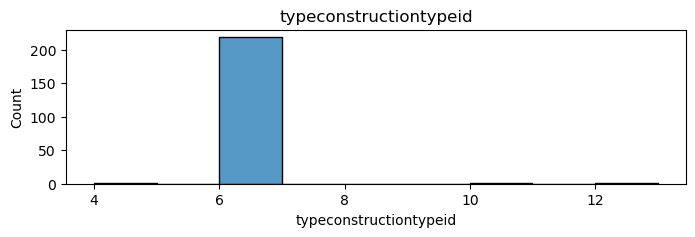

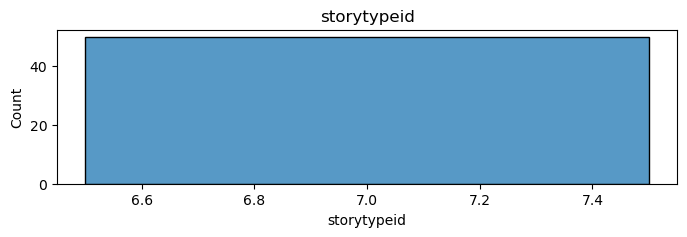

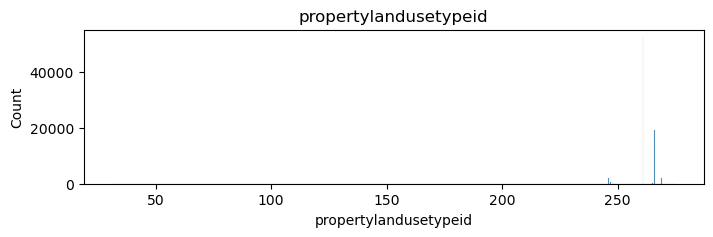

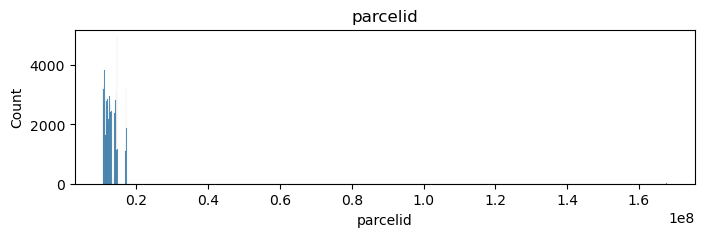

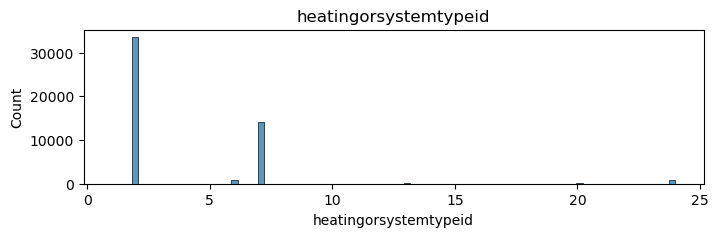

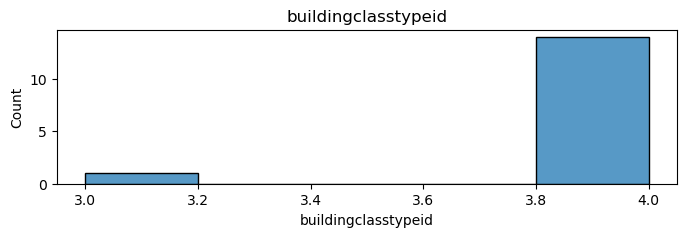

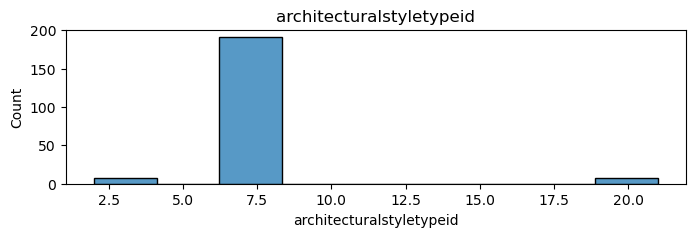

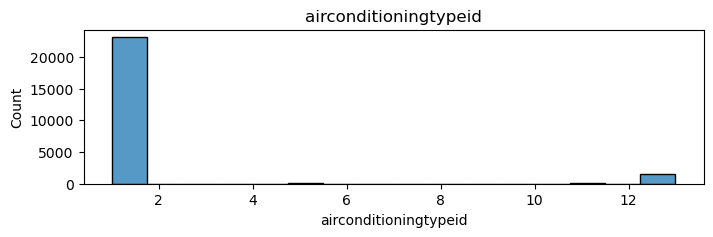

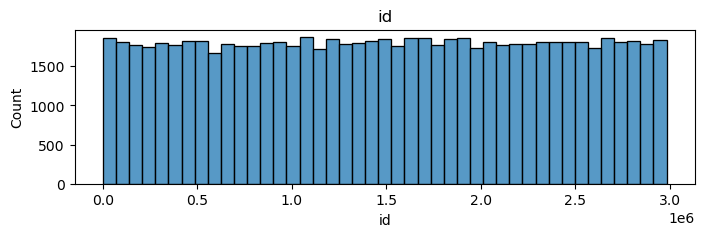

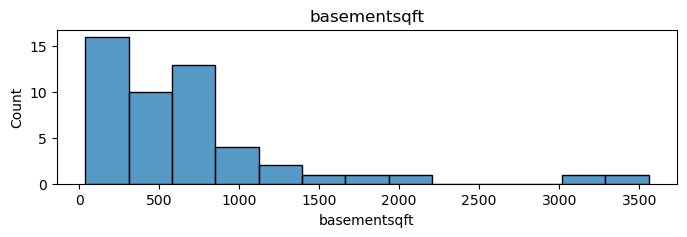

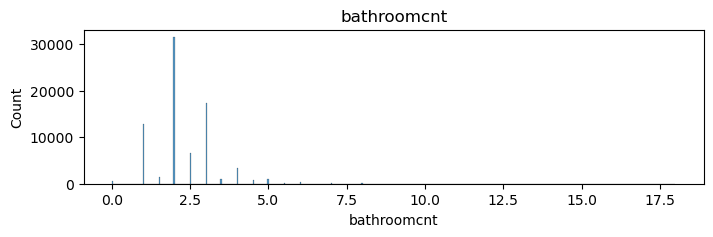

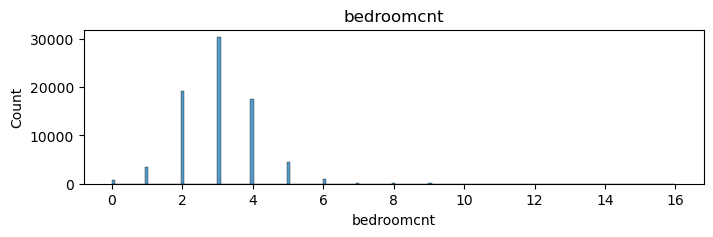

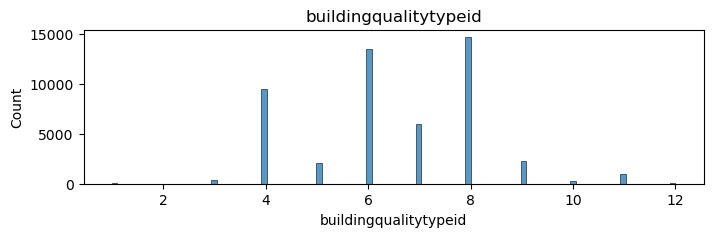

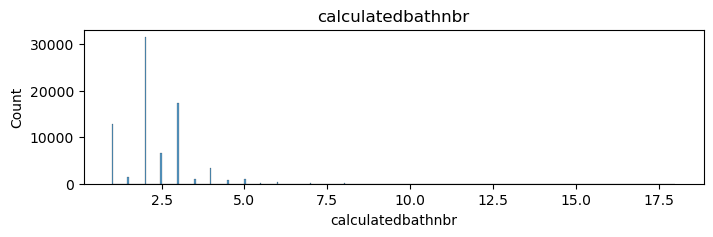

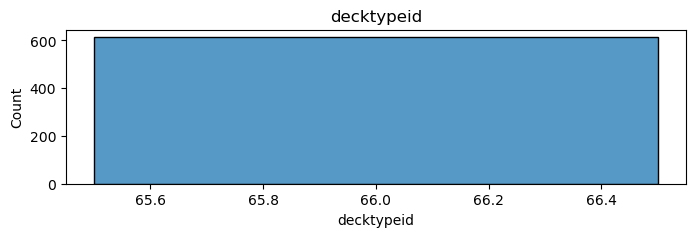

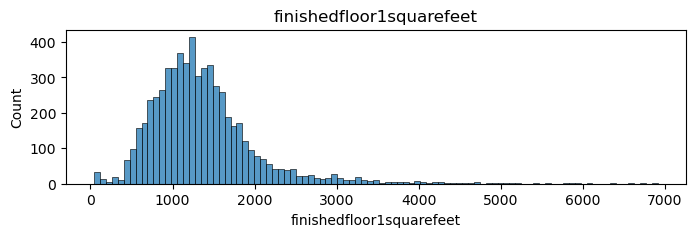

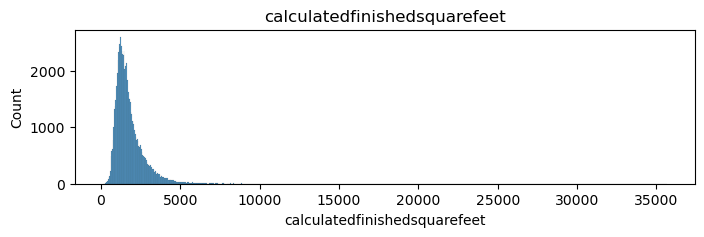

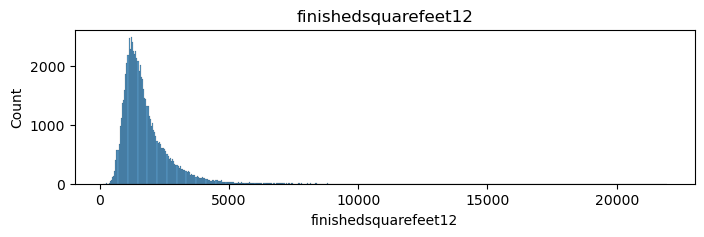

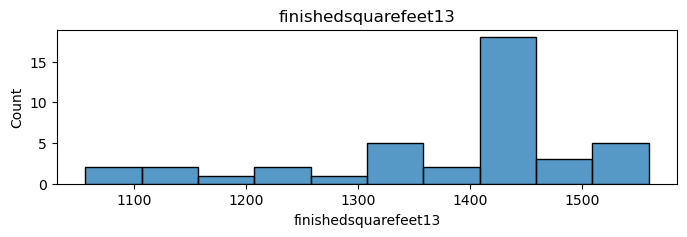

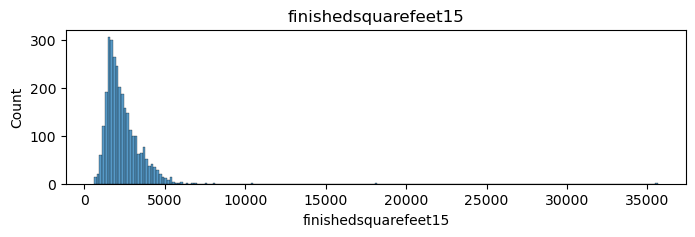

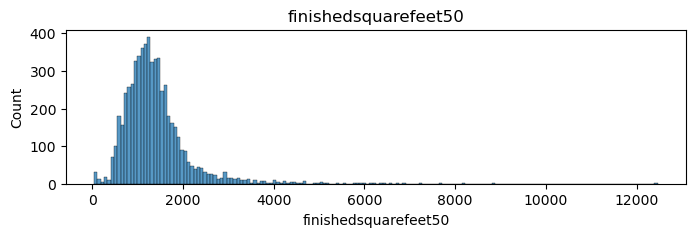

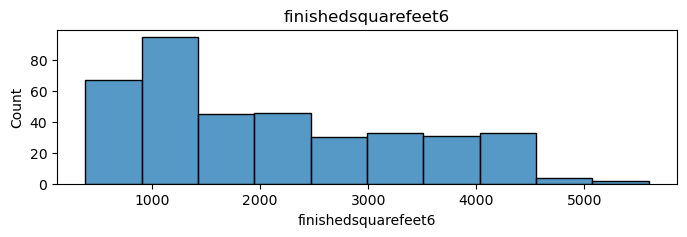

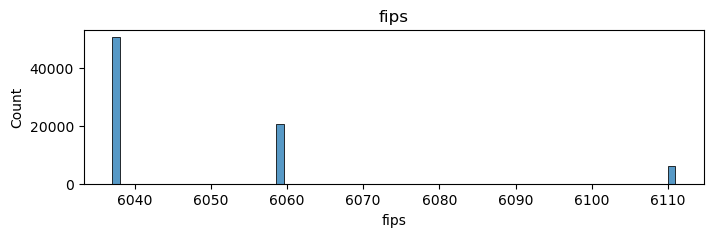

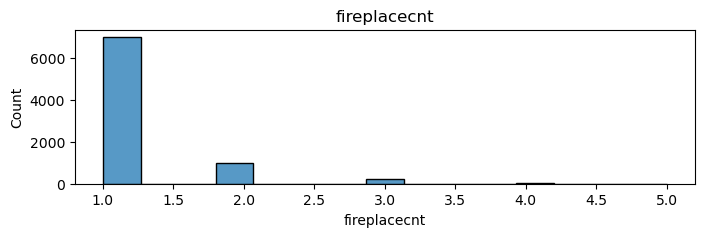

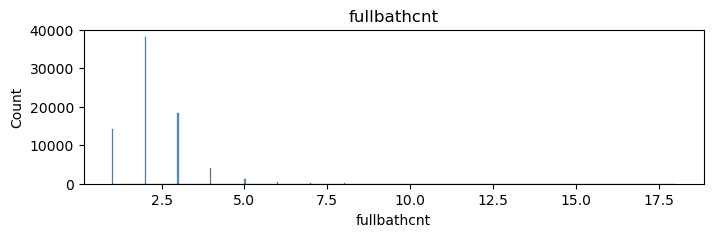

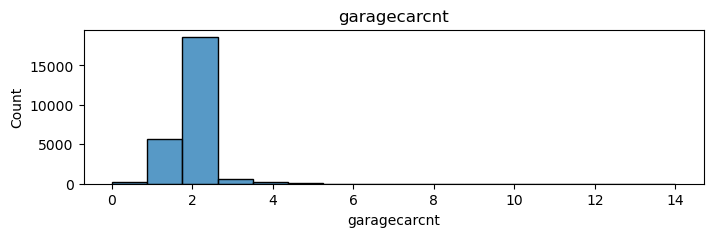

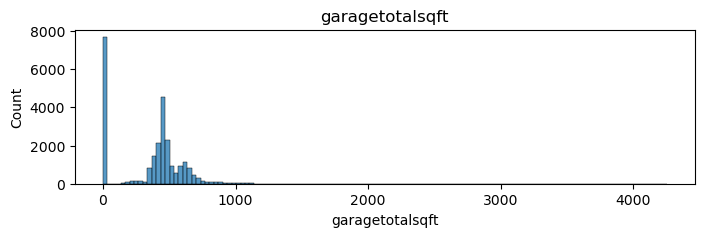

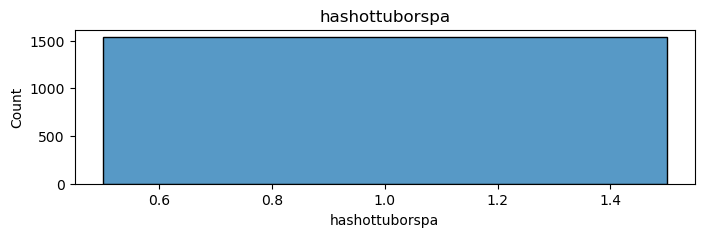

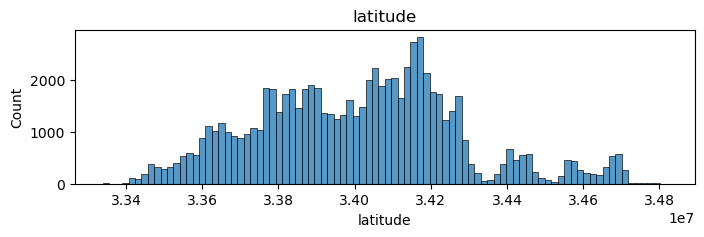

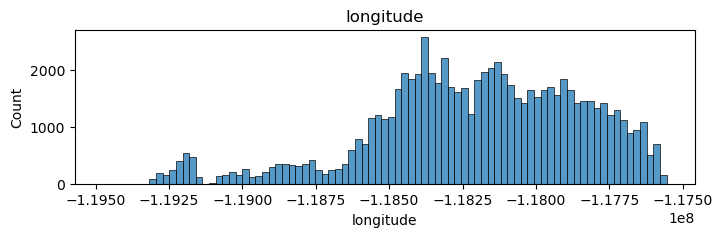

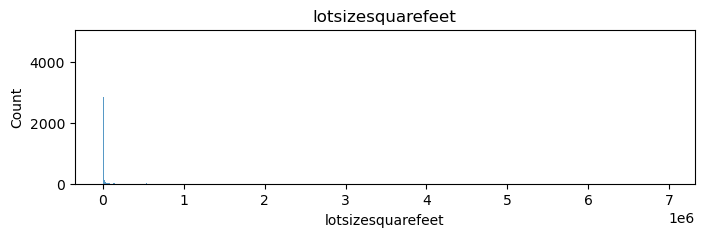

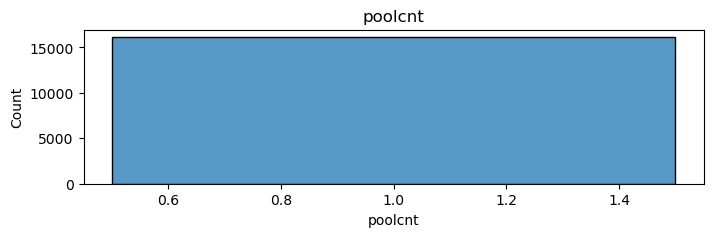

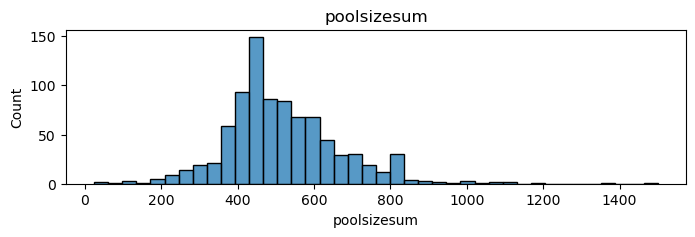

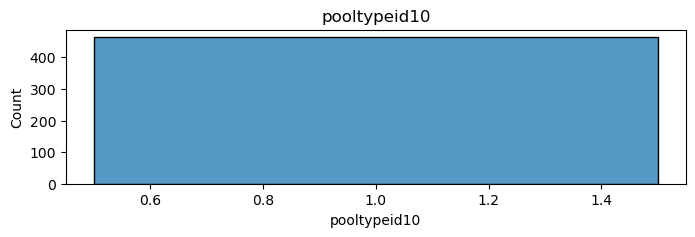

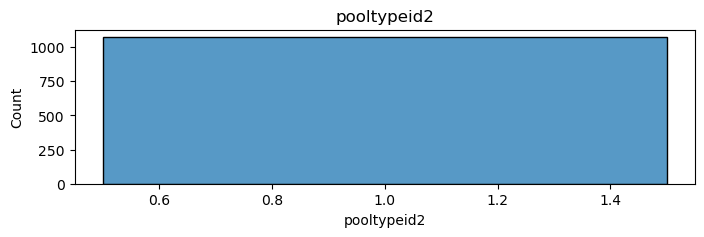

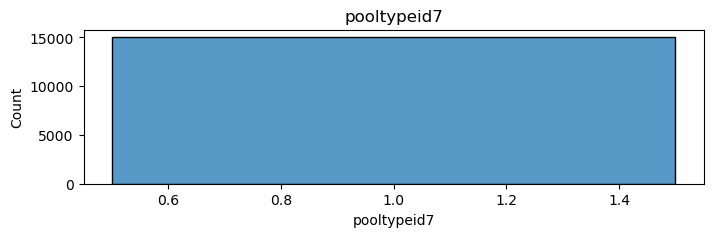

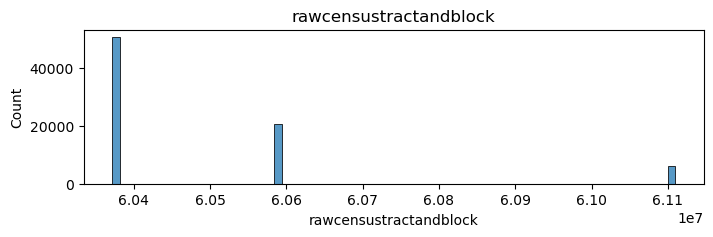

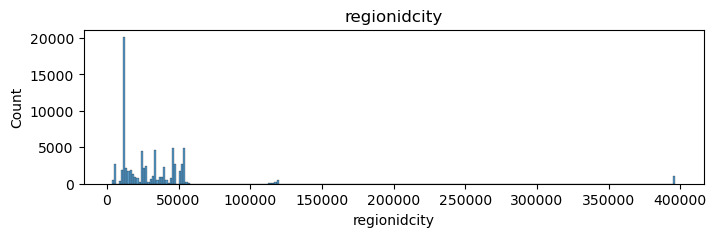

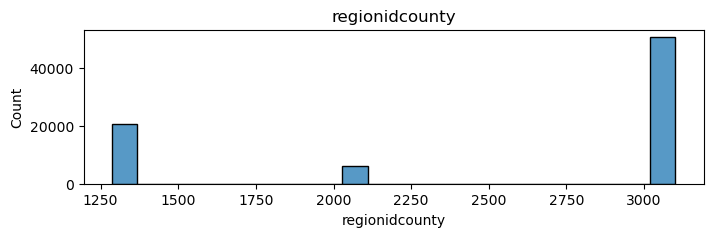

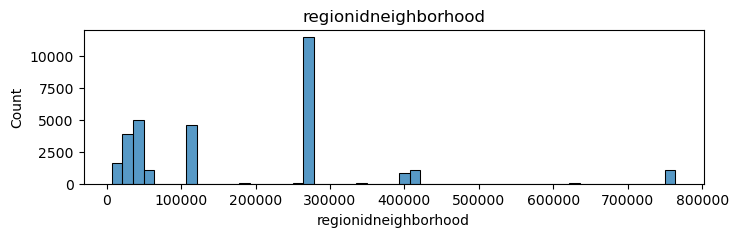

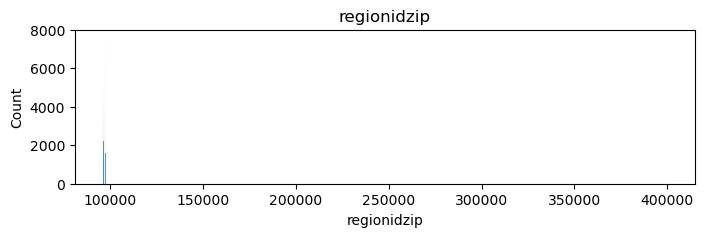

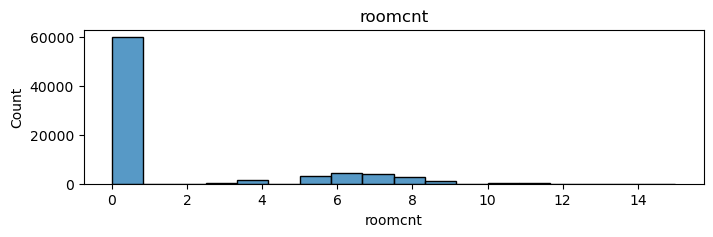

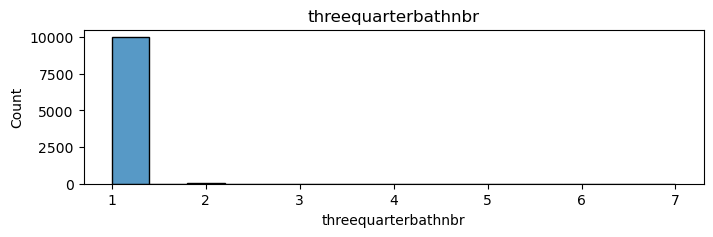

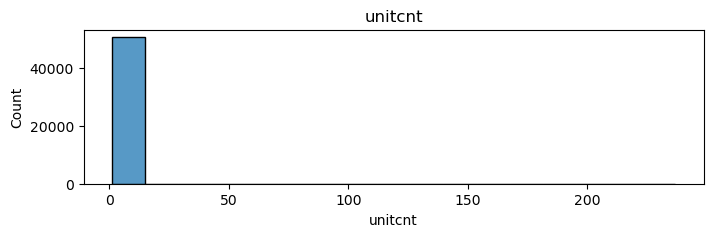

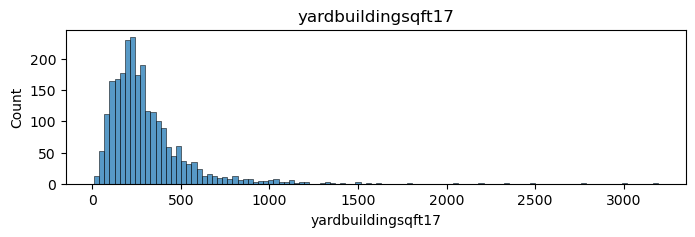

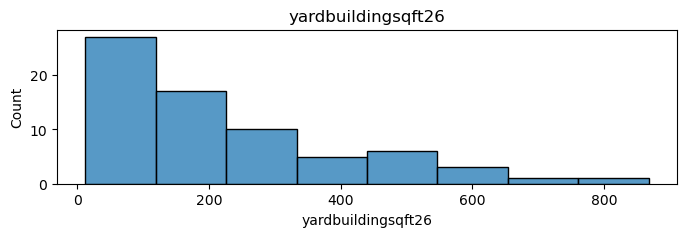

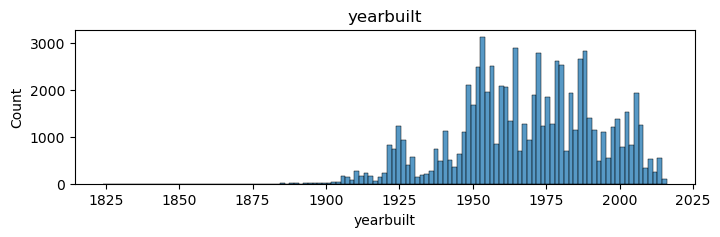

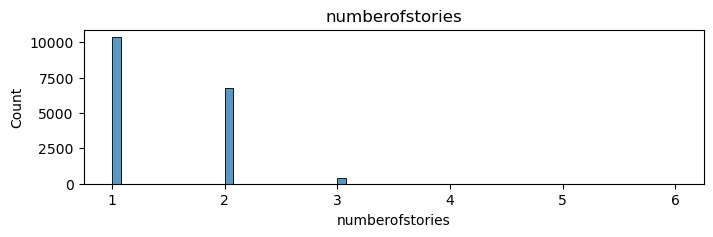

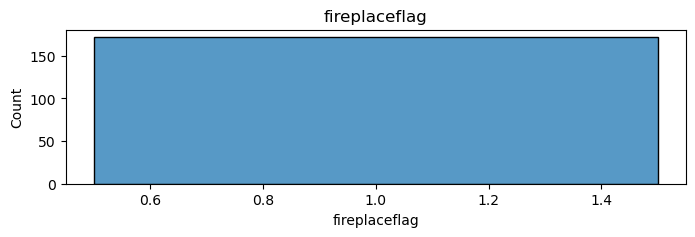

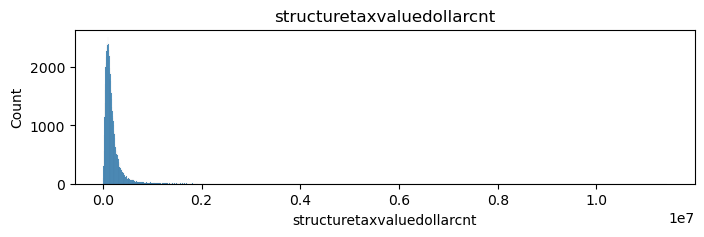

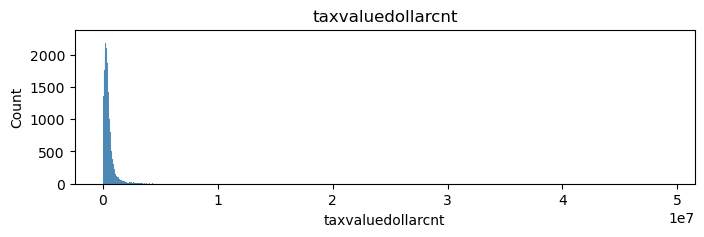

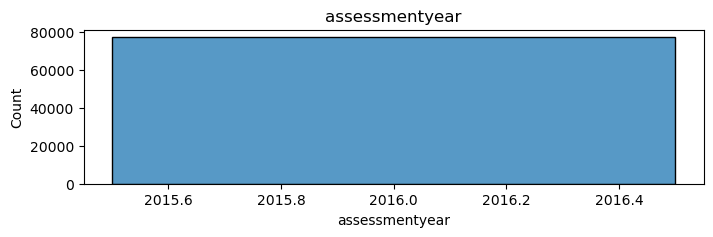

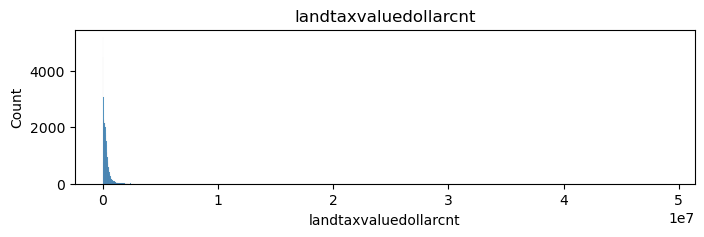

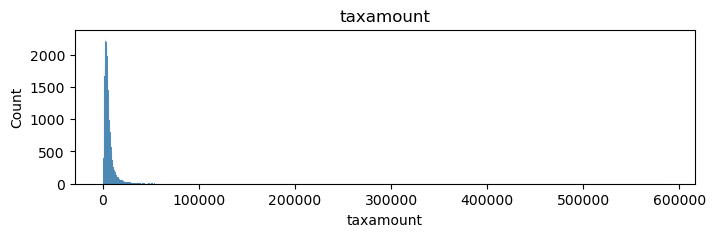

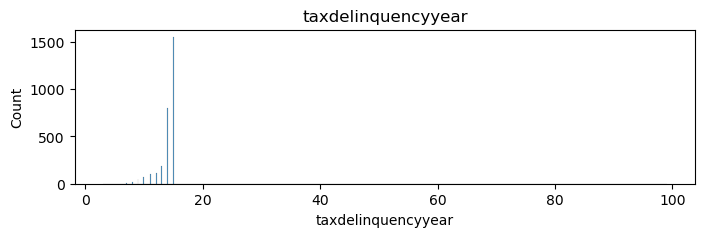

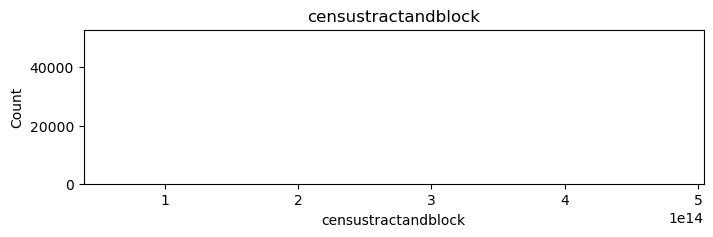

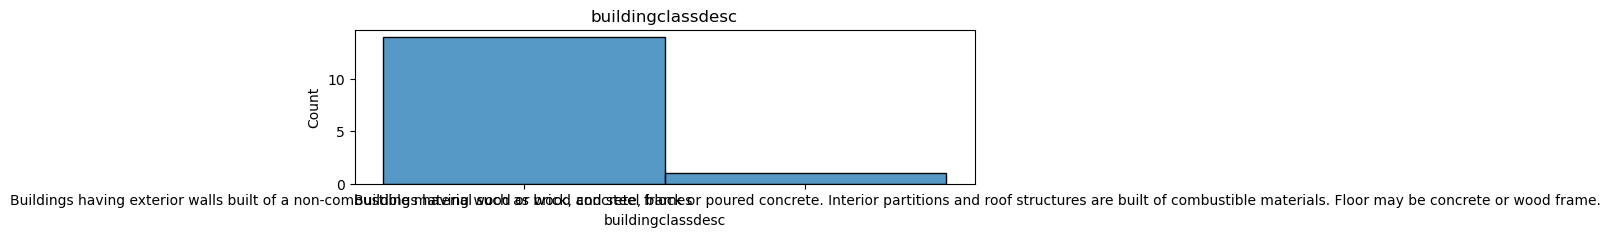

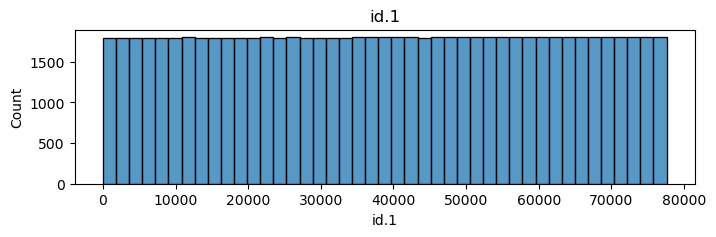

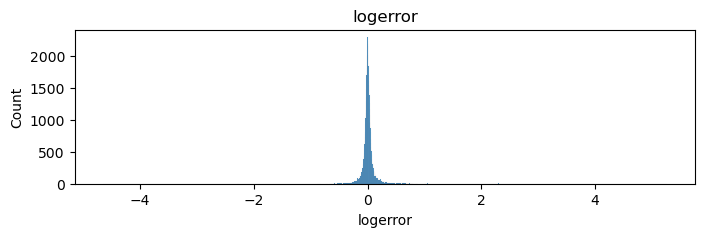

,col_name,dtype,num_unique,num_null,pct_null,unique_values,"range (min, max, mean)"
0,typeconstructiontypeid,float64,4,77159,1.00,"[nan, 6.0, 13.0, 10.0, 4.0]","[4.0, 13.0, 6.04054054054054]"
1,storytypeid,float64,1,77331,1.00,"[nan, 7.0]","[7.0, 7.0, 7.0]"
2,propertylandusetypeid,float64,13,0,0.00,"[261.0, 266.0, 246.0, 260.0, 269.0, 247.0, 248...","[31.0, 275.0, 261.8263397991755]"
3,parcelid,int64,77381,0,0.00,"[14297519, 17052889, 14186244, 12177905, 10887...","[10711855.0, 167689317.0, 13007150.505731381]"
4,heatingorsystemtypeid,float64,10,27941,0.36,"[nan, 2.0, 7.0, 6.0, 24.0, 13.0, 18.0, 20.0, 1...","[1.0, 24.0, 3.920509708737864]"
5,buildingclasstypeid,float64,2,77366,1.00,"[nan, 4.0, 3.0]","[3.0, 4.0, 3.933333333333333]"
6,architecturalstyletypeid,float64,5,77175,1.00,"[nan, 7.0, 8.0, 21.0, 3.0, 2.0]","[2.0, 21.0, 7.388349514563107]"
7,airconditioningtypeid,float64,5,52428,0.68,"[nan, 1.0, 13.0, 5.0, 11.0, 9.0]","[1.0, 13.0, 1.8132889832885826]"
8,id,int64,77381,0,0.00,"[1727539, 1387261, 11677, 2288172, 1970746, 14...","[349.0, 2982274.0, 1495138.9017588296]"
9,basementsqft,float64,43,77331,1.00,"[nan, 900.0, 1416.0, 224.0, 100.0, 512.0, 380....","[38.0, 3560.0, 679.72]"


In [155]:
check_columns(df, reports=True, graphs=True)

#### 3. 

Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values.

##### The output should look like the table below:


|  | num_rows_missing | pct_rows_missing|
| - |------------------|-----------------|
| parcelid | 0 | 0.000000|
| airconditioningtypeid | 29041 | 0.535486|
| architecturalstyletypeid | 54232 | 0.999982 |

In [156]:
def check_columns_only_nulls(df):
    """
    This function takes a pandas dataframe as input and returns
    a dataframe with information about each column in the dataframe. For
    each column, it returns the column name, the number of
    unique values in the column, the unique values themselves,
    the number of null values in the column, the proportion of null values,
    and the data type of the column. The resulting dataframe is sorted by the
    'Number of Unique Values' column in ascending order.

    Args:
    - df: pandas dataframe

    Returns:
    - pandas dataframe
    """
    data = []
    # Loop through each column in the dataframe
    for column in df.columns:
        # Append the column name, number of null values, proportion of null values
        data.append(
            [
                column,
                # df[column].nunique(),
                # df[column].unique(),
                df[column].isna().sum(),
                df[column].isna().mean(),
                # df[column].dtype,
            ]
        )
    # Create a pandas dataframe from the data list, with column names 'Column Name', 'Number of Null Values', 'Proportion of Null Values',
    return pd.DataFrame(
        data,
        columns=[
            "column_name",
            # "Number of Unique Values",
            # "Unique Values",
            "num_rows_missing",
            "pct_rows_missing",
            # "dtype",
        ],
    )

In [157]:
check_columns_only_nulls(df)

,column_name,num_rows_missing,pct_rows_missing
0,typeconstructiontypeid,77159,1.00
1,storytypeid,77331,1.00
2,propertylandusetypeid,0,0.00
3,parcelid,0,0.00
4,heatingorsystemtypeid,27941,0.36
5,buildingclasstypeid,77366,1.00
6,architecturalstyletypeid,77175,1.00
7,airconditioningtypeid,52428,0.68
8,id,0,0.00
9,basementsqft,77331,1.00


### Prepare

#### 1. 

Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer.


##### Definining `single unit property` as:

```"A single-unit property is a rental property that is rented as a single entity. A condo, a townhouse, or a vacation rental would typically be single-unit properties. If you’re adding a single-unit property to Renting Well you don’t need to add individual units – the tenant and lease are associated to the property itself."```

In [158]:
df.value_counts("propertylandusedesc")

propertylandusedesc
Single Family Residential                     52320
Condominium                                   19294
Duplex (2 Units, Any Combination)              2009
Planned Unit Development                       1944
Quadruplex (4 Units, Any Combination)           727
Triplex (3 Units, Any Combination)              535
Cluster Home                                    333
Mobile Home                                      74
Manufactured, Modular, Prefabricated Homes       58
Residential General                              37
Cooperative                                      29
Commercial/Office/Residential Mixed Used         15
Townhouse                                         6
Name: count, dtype: int64

Dropping these columns, because they are most likely not single family homes

`Cooperative`

`Planned Unit Development`

`Triplex (3 Units, Any Combination)`

`Quadruplex (4 Units, Any Combination)`

`Cluster Home`

`Commercial/Office/Residential Mixed Used`

`Duplex (2 Units, Any Combination)`

In [159]:
# Single Family Homes
single_fam = [
    "Single Family Residential",
    "Condominium",
    "Residential General",
    "Manufactured, Modular, Prefabricated Homes",
    "Mobile Home",
    "Townhouse",
]

df = df[df["propertylandusedesc"].isin(single_fam)]

In [160]:
check_columns(df)

Total rows: 71789
Total columns: 69


,col_name,dtype,num_unique,num_null,pct_null,unique_values,"range (min, max, mean)"
0,typeconstructiontypeid,float64,4,71567,1.00,"[nan, 6.0, 13.0, 10.0, 4.0]","[4.0, 13.0, 6.04054054054054]"
1,storytypeid,float64,1,71742,1.00,"[nan, 7.0]","[7.0, 7.0, 7.0]"
2,propertylandusetypeid,float64,6,0,0.00,"[261.0, 266.0, 260.0, 275.0, 263.0, 264.0]","[260.0, 275.0, 262.35690704704064]"
3,parcelid,int64,71789,0,0.00,"[14297519, 17052889, 14186244, 12177905, 10887...","[10711855.0, 167688532.0, 13044089.102327654]"
4,heatingorsystemtypeid,float64,10,25218,0.35,"[nan, 2.0, 7.0, 6.0, 24.0, 13.0, 18.0, 20.0, 1...","[1.0, 24.0, 3.9508062957634578]"
5,buildingclasstypeid,float64,0,71789,1.00,[nan],"[nan, nan, nan]"
6,architecturalstyletypeid,float64,5,71583,1.00,"[nan, 7.0, 8.0, 21.0, 3.0, 2.0]","[2.0, 21.0, 7.388349514563107]"
7,airconditioningtypeid,float64,4,48762,0.68,"[nan, 1.0, 13.0, 5.0, 11.0]","[1.0, 13.0, 1.8686324749207452]"
8,id,int64,71789,0,0.00,"[1727539, 1387261, 11677, 2288172, 1970746, 14...","[349.0, 2982274.0, 1495246.7838387496]"
9,basementsqft,float64,41,71742,1.00,"[nan, 900.0, 1416.0, 224.0, 100.0, 512.0, 380....","[38.0, 3560.0, 678.9787234042553]"



#### 2. 

Create a function that will drop rows or columns based on the percent of values that are missing: handle_missing_values(df, prop_required_column, prop_required_row).


**The input:**
- A dataframe

- A number between 0 and 1 that represents the proportion, for each column, of rows with non-missing values required to keep the column. i.e. if prop_required_column = .6, then you are requiring a column to have at least 60% of values not-NA (no more than 40% missing).

- A number between 0 and 1 that represents the proportion, for each row, of columns/variables with non-missing values required to keep the row. For example, if prop_required_row = .75, then you are requiring a row to have at least 75% of variables with a non-missing value (no more that 25% missing).

**The output:**

- The dataframe with the columns and rows dropped as indicated. Be sure to drop the columns prior to the rows in your function.

- (Hint) Look up the dropna documentation.

- You will want to compute a threshold from your input values (prop_required) and total number of rows or columns.

In [161]:
def handle_missing_values(df, column_pct, row_pct):
    """
    Drop rows or columns based on the percent of values that are missing.

    Parameters:
    df (pandas.DataFrame): The input dataframe.
    prop_required_column (float): The proportion of non-missing values required to keep a column.
    prop_required_row (float): The proportion of non-missing values required to keep a row.

    Returns:
    pandas.DataFrame: The dataframe with missing values handled.
    """
    temp_df = df
    # Drop columns with too many missing values
    threshold = int(round(column_pct * len(df.index), 0))
    temp_df.dropna(axis=1, thresh=threshold, inplace=True)

    # Drop rows with too many missing values
    threshold = int(round(row_pct * len(df.columns), 0))
    temp_df.dropna(axis=0, thresh=threshold, inplace=True)

    return temp_df

In [162]:
df1 = handle_missing_values(df, 0.75, 0.75)

check_columns(df1)

Total rows: 71786
Total columns: 30


,col_name,dtype,num_unique,num_null,pct_null,unique_values,"range (min, max, mean)"
0,propertylandusetypeid,float64,6,0,0.00,"[261.0, 266.0, 260.0, 275.0, 263.0, 264.0]","[260.0, 275.0, 262.356894101914]"
1,parcelid,int64,71786,0,0.00,"[14297519, 17052889, 14186244, 12177905, 10887...","[10711855.0, 167688532.0, 13037626.417267991]"
2,id,int64,71786,0,0.00,"[1727539, 1387261, 11677, 2288172, 1970746, 14...","[349.0, 2982274.0, 1495239.4620678127]"
3,bathroomcnt,float64,22,0,0.00,"[3.5, 1.0, 2.0, 3.0, 2.5, 4.5, 4.0, 0.0, 5.0, ...","[0.0, 18.0, 2.2609701055916194]"
4,bedroomcnt,float64,14,0,0.00,"[4.0, 2.0, 3.0, 6.0, 5.0, 1.0, 0.0, 7.0, 8.0, ...","[0.0, 14.0, 2.9999721394143704]"
5,calculatedbathnbr,float64,21,268,0.00,"[3.5, 1.0, 2.0, 3.0, 2.5, 4.5, 4.0, nan, 5.0, ...","[1.0, 18.0, 2.26893928801141]"
6,calculatedfinishedsquarefeet,float64,4838,185,0.00,"[3100.0, 1465.0, 1243.0, 2376.0, 1312.0, 1492....","[128.0, 21929.0, 1752.150277230765]"
7,finishedsquarefeet12,float64,4834,404,0.01,"[3100.0, 1465.0, 1243.0, 2376.0, 1312.0, 1492....","[128.0, 21929.0, 1753.6921072539296]"
8,fips,float64,3,0,0.00,"[6059.0, 6111.0, 6037.0]","[6037.0, 6111.0, 6049.2532527233725]"
9,fullbathcnt,float64,13,268,0.00,"[3.0, 1.0, 2.0, 4.0, nan, 5.0, 6.0, 9.0, 8.0, ...","[1.0, 18.0, 2.1984255711848766]"


#### 3. 

Encapsulate your work inside of functions in a wrangle_zillow.py module.

In [45]:
# Added all above functions to wrangle_zillow.py

## Mall Customers

### 1. 
Acquire data from the customers table in the mall_customers database.

In [46]:
import os
import pandas as pd
import wrangle_zillow as w
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler


def acquire_mall():
    """
    acquire_mall will use a local env.py
    using pre-set credentials called user, password, and host
    please make sure you have a properly formatted env.py
    file in the same directory as this module
    and that you have the access rights to mall_customers schema

    return: a single pandas dataframe
    """
    if os.path.exists("mall_data.csv"):
        df = pd.read_csv("mall_data.csv")
    else:
        df = pd.read_sql(
            """
                        SELECT *
                        FROM customers
                        """,
            f"mysql+pymysql://{user}:{password}@{host}/mall_customers",
        )
        df.to_csv("mall_data.csv", index=False)
    return df

In [47]:
mall = acquire_mall()

### 2. 
Summarize the data (include distributions and descriptive statistics).

Total rows: 200
Total columns: 5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     200 non-null    int64 
 1   gender          200 non-null    object
 2   age             200 non-null    int64 
 3   annual_income   200 non-null    int64 
 4   spending_score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
                              count                 mean                  std  \
customer_id                  200.00               100.50                57.88   
age                          200.00                38.85                13.97   
annual_income                200.00                60.56                26.26   
spending_score               200.00                50.20                25.82   

                                min                  25%                  50%  \
customer_id  

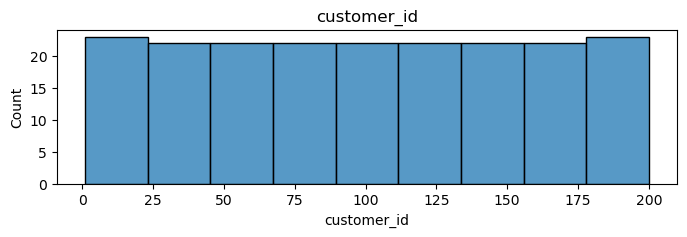

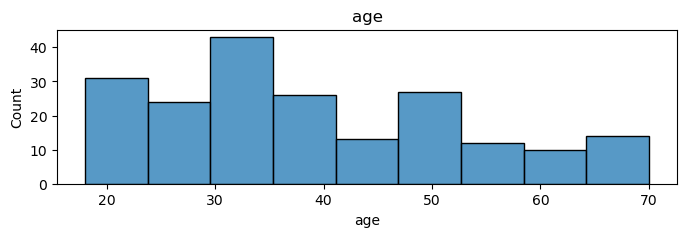

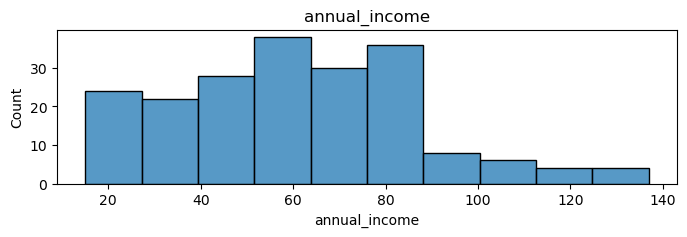

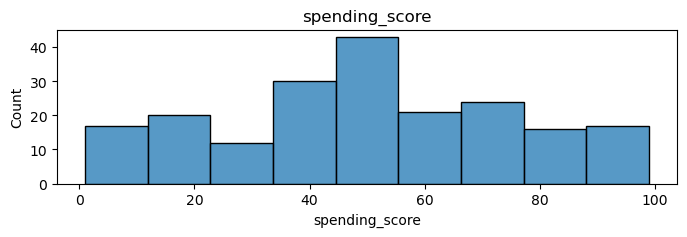

,col_name,dtype,num_unique,num_null,pct_null,unique_values,"range (min, max, mean)"
0,customer_id,int64,200,0,0.00,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.0, 200.0, 100.5]"
1,gender,object,2,0,0.00,"[Male, Female]",None
2,age,int64,51,0,0.00,"[19, 21, 20, 23, 31, 22, 35, 64, 30, 67, 58, 2...","[18.0, 70.0, 38.85]"
3,annual_income,int64,64,0,0.00,"[15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 28, 2...","[15.0, 137.0, 60.56]"
4,spending_score,int64,84,0,0.00,"[39, 81, 6, 77, 40, 76, 94, 3, 72, 14, 99, 15,...","[1.0, 99.0, 50.2]"


In [49]:
w.check_columns(mall, reports=True, graphs=True)

### 3. 
Detect outliers using IQR.


In [146]:
def box_plotter(df):
    """
    Generates a box plot for all columns in a dataframe using matplotlib.
    """
    for col in df.columns:
        try:
            plt.figure(figsize=(12, 1))
            plt.boxplot(df[col], vert=False)
            # plt.title(col)
            plt.title(
                f"{col} (Mean: {df[col].mean()}) (Median: {df[col].median()}) (Mode: {df[col].mode().iloc[0]})"
            )
            plt.show()
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            print(
                f"Number of results in outer-lower quartile: {len(df[df[col] < lower_bound])} ({(len(df[df[col] < lower_bound])/len(df))*100:.2f}%)"
            )
            print(
                f"Number of results in inner quartile: {len(df[(df[col] >= lower_bound) & (df[col] <= upper_bound)])} ({(len(df[(df[col] >= lower_bound) & (df[col] <= upper_bound)])/len(df))*100:.2f}%)"
            )
            print(
                f"Number of results in outer-upper quartile: {len(df[df[col] > upper_bound])} ({(len(df[df[col] > upper_bound])/len(df))*100:.2f}%)"
            )
        except:
            print(
                f"\nError: Could not generate for column {col}. Skipping to next column...\n"
            )
            plt.close()
            continue

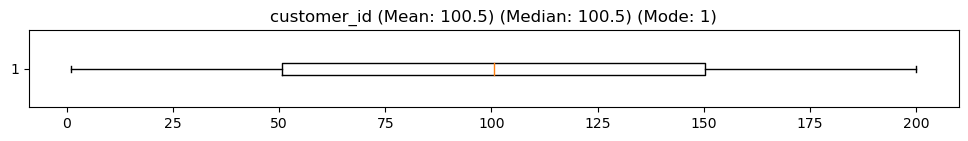

Number of results in outer-lower quartile: 0 (0.00%)
Number of results in inner quartile: 200 (100.00%)
Number of results in outer-upper quartile: 0 (0.00%)

Error: Could not generate for column gender. Skipping to next column...



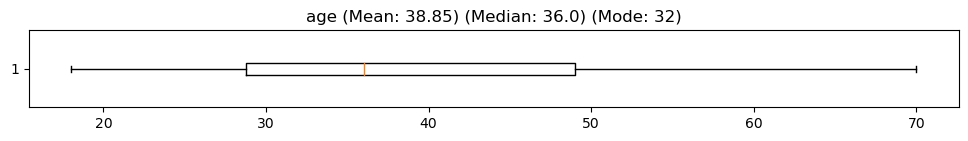

Number of results in outer-lower quartile: 0 (0.00%)
Number of results in inner quartile: 200 (100.00%)
Number of results in outer-upper quartile: 0 (0.00%)


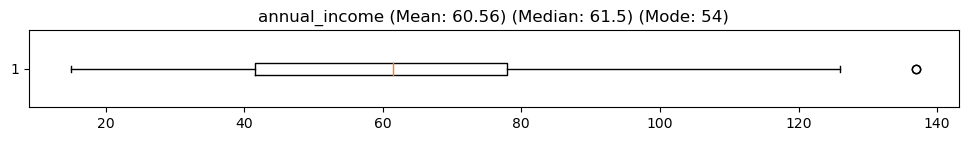

Number of results in outer-lower quartile: 0 (0.00%)
Number of results in inner quartile: 198 (99.00%)
Number of results in outer-upper quartile: 2 (1.00%)


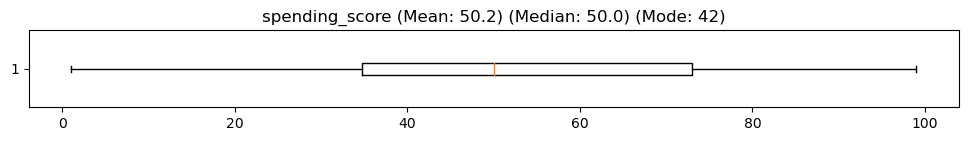

Number of results in outer-lower quartile: 0 (0.00%)
Number of results in inner quartile: 200 (100.00%)
Number of results in outer-upper quartile: 0 (0.00%)


In [147]:
box_plotter(mall)

### 4. 
Split data into train, validate, and test.


In [52]:
def split_data(df, random_state=123):
    """Split into train, validate, test with a 60% train, 20% validate, 20% test"""
    train_validate, test = train_test_split(df, test_size=0.2, random_state=123)
    train, validate = train_test_split(train_validate, test_size=0.25, random_state=123)

    print(f"train: {len(train)} ({round(len(train)/len(df)*100)}% of {len(df)})")
    print(
        f"validate: {len(validate)} ({round(len(validate)/len(df)*100)}% of {len(df)})"
    )
    print(f"test: {len(test)} ({round(len(test)/len(df)*100)}% of {len(df)})")
    return train, validate, test

In [53]:
train, val, test = split_data(mall)

train: 120 (60% of 200)
validate: 40 (20% of 200)
test: 40 (20% of 200)


### 5. 
Encode categorical columns using a one hot encoder (pd.get_dummies).

#### Encoded columns before train, test, split, to avoid having to encode each set separately

In [54]:
def encode_columns(df, columns, drop_first=True):
    """
    Encode the specified columns of a dataframe using pd.get_dummies.

    Parameters:
    df (pandas.DataFrame): The input dataframe.
    columns (list): A list of column names to encode.

    Returns:
    pandas.DataFrame: The encoded dataframe.
    """
    # Encode the specified columns using pd.get_dummies
    df_encoded = pd.get_dummies(df, columns=columns, drop_first=drop_first)

    return df_encoded

In [55]:
# Typically I would encode before train, val, test splitting to avoid redundancy.

col_to_encode = ["gender"]

train = encode_columns(train, col_to_encode, drop_first=True)
val = encode_columns(val, col_to_encode, drop_first=True)
test = encode_columns(test, col_to_encode, drop_first=True)

### 6. 
Handles missing values.


In [56]:
# Check the dataframe for any nulls

mall.isnull().sum()

customer_id       0
gender            0
age               0
annual_income     0
spending_score    0
dtype: int64

### 7. 
Scaling



In [57]:
# # Scaled using MinMax due to minimal outliers

# from sklearn.preprocessing import MinMaxScaler


# def min_max_scale(train, validate, test, scaled_features=None, scaler="MM"):
#     """
#     This function takes in 3 dataframes (train, validate, test)
#     scales them using MinMaxScaler and returns the scaled dataframes.
#     """
#     if scaled_features is None:
#         # If scaled_features is not defined, scale all object columns
#         object_cols = train.select_dtypes(include=["object"]).columns.to_list()
#         scaled_features = object_cols

#     if scaler == "MM":
#         # Make the thing
#         scaler = MinMaxScaler()
#         # We fit/transform on itself to prevent leakage of one set into the other
#         # Training
#         train_scaled = train.copy()
#         train_scaled[scaled_features] = scaler.fit_transform(train[scaled_features])
#         # Validate
#         validate_scaled = validate.copy()
#         validate_scaled[scaled_features] = scaler.transform(validate[scaled_features])
#         # Test
#         test_scaled = test.copy()
#         test_scaled[scaled_features] = scaler.transform(test[scaled_features])

#         return train_scaled, validate_scaled, test_scaled

In [58]:
def multi_scaler(train, val, test, scaled_features=None, scaler="MM"):
    """
    This function takes in 3 dataframes (train, val, test)
    and scales them using the specified scaler.

    Parameters:
    train (pandas.DataFrame): The training dataframe.
    val (pandas.DataFrame): The validation dataframe.
    test (pandas.DataFrame): The test dataframe.
    scaled_features (list): A list of column names to scale. If None, all object columns are scaled.
    scaler (str): The scaler to use. Must be one of "MM" (MinMaxScaler), "Standard" (StandardScaler), or "Robust" (RobustScaler).

    Returns:
    tuple: A tuple of the scaled dataframes (train_scaled, val_scaled, test_scaled).
    """
    if scaled_features is None:
        # If scaled_features is not defined, scale all numeric columns
        numeric_cols = train.select_dtypes(include=["number"]).columns.to_list()
        if len(numeric_cols) == 0:
            raise ValueError("No numeric columns to scale.")
        scaled_features = numeric_cols

    if scaler == "MM":
        scaler_obj = MinMaxScaler()
    elif scaler == "Standard":
        scaler_obj = StandardScaler()
    elif scaler == "Robust":
        scaler_obj = RobustScaler()
    else:
        raise ValueError(
            "Invalid scaler. Must be one of 'MM', 'Standard', or 'Robust'."
        )

    # We fit/transform on itself to prevent leakage of one set into the other
    # Training
    train_scaled = train.copy()
    train_scaled[scaled_features] = scaler_obj.fit_transform(train[scaled_features])
    # Validation
    val_scaled = val.copy()
    val_scaled[scaled_features] = scaler_obj.transform(val[scaled_features])
    # Test
    test_scaled = test.copy()
    test_scaled[scaled_features] = scaler_obj.transform(test[scaled_features])

    return train_scaled, val_scaled, test_scaled

In [59]:
train.dtypes

customer_id       int64
age               int64
annual_income     int64
spending_score    int64
gender_Male        bool
dtype: object

In [60]:
train_robust, val_robust, test_roboust = multi_scaler(train, val, test, scaler="Robust")

### 8. 
Encapsulate your work in a `wrangle_mall.py` python module.

In [61]:
# All functions added to wrangle_mall.py